https://stepik.org/lesson/1576177/step/5

Parameter containing:
tensor([[-0.0517,  0.0913,  0.0049, -0.0359,  0.1033, -0.0116]],
       requires_grad=True) Parameter containing:
tensor([-0.0058], requires_grad=True)


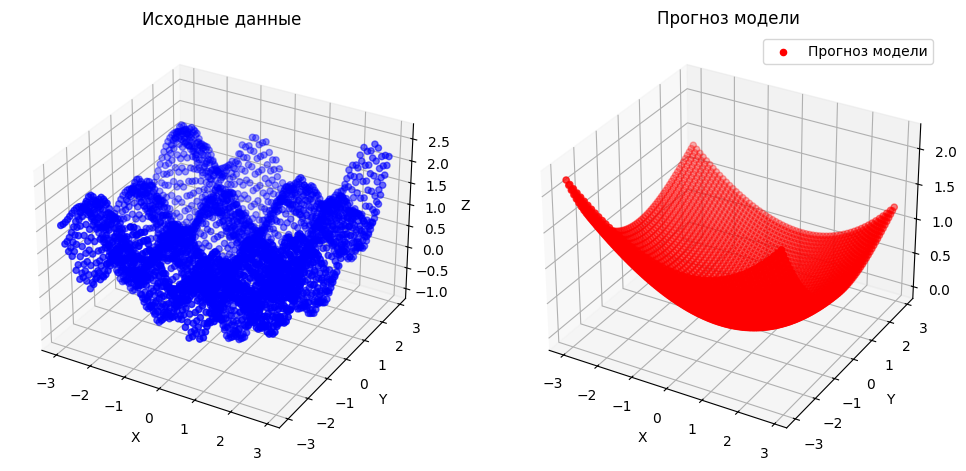

In [ ]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

class FuncDataset(data.Dataset):
    def __init__(self):
        _range = torch.arange(-3, 3, 0.1)
        self.data = torch.tensor([(_x, _y) for _x in _range for _y in _range])
        self.target = self._func(self.data)
        self.length = len(self.data)

    @staticmethod
    def _func(coord):
        _x, _y = coord[:, 0], coord[:, 1]
        return torch.sin(2 * _x) * torch.cos(3 * _y) + 0.2 * torch.cos(10 * _x) * torch.sin(8 * _x) + 0.1 * _x ** 2 + 0.1 * _y ** 2

    def __getitem__(self, item):
        return self.data[item], self.target[item]

    def __len__(self):
        return self.length


class FuncModel(nn.Module):
    def __init__(self):
        super().__init__()
        # модель однослойной полносвязной нейронной сети:
        self.layer1 = nn.Linear(6, 1)

    def forward(self, coord):
        x, y = coord[:, 0], coord[:, 1]
        x.unsqueeze_(-1)
        y.unsqueeze_(-1)

        xx = torch.empty(coord.size(0), 6)
        xx[:, :3] = torch.cat([x, x ** 2, x ** 3], dim=1)
        xx[:, 3:] = torch.cat([y, y ** 2, y ** 3], dim=1)
        y = self.layer1(xx)
        return y

# Создание модели FuncModel и перевод в режим обучения
model = FuncModel()
model.train()

# Параметры градиентного спуска
epochs = 20     # число эпох обучения
batch_size = 16 # размер батча
lr = 0.01

# Создание датасета с разбиением на батчи
d_train = FuncDataset()
train_data = data.DataLoader(d_train, batch_size, shuffle=True, drop_last=False)

# Оптимизатор и функция потерь
optimizer = optim.RMSprop(params=model.parameters(), lr=lr)
loss_func = torch.nn.MSELoss()

# Градиентный спуск
for _e in range(epochs):
    for x_train, y_train in train_data:
        predict = model(x_train).squeeze()
        loss = loss_func(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Перевод модели в режим эксплуатации
model.eval()

# Прогноз модели по всем данным выборки
y_pred = model(d_train.data)

# Качество
Q = loss_func(y_pred.data.squeeze(), d_train.target).item()

# Вычисленные параметры многочлена (веса и смещение)
print(*model.parameters())

# График
import matplotlib.pyplot as plt

x = d_train.data[:, 0]
y = d_train.data[:, 1]
z_real = d_train.target
z_pred = y_pred.data.squeeze()

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x, y, z_real, c='b', label='Исходные данные')
ax1.set_title('Исходные данные')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x, y, z_pred, c='r', label='Прогноз модели')
ax2.set_title('Прогноз модели')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.legend()
plt.show()